In [1]:
%%capture
!pip install catboost
!pip install opentsne
!pip install umap-learn

In [2]:
#!pip install lightgbm

In [3]:
# Импорт библиотек
# Data manipulation
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

# Data preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# Dimensionality Reduction
from openTSNE.sklearn import TSNE
import umap
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.multiclass import OneVsRestClassifier

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Импорт данных
df = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_05_visualization/wine.csv')
df.head()

,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
# Размер датафрейма: 178 строк, 14 колонок
df.shape

(178, 14)

In [6]:
# Информация о датафрейме. Пропущенных значений нет.
# 13 характеристик вина: Alcohol, Malic, Ash, Alcalinity, Magnesium, Phenols, Flavanoids, Nonflavanoids, Proanthocyanins, 
# Color, Hue, Dilution, Proline.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             178 non-null    int64  
 1   Alcohol          178 non-null    float64
 2   Malic            178 non-null    float64
 3   Ash              178 non-null    float64
 4   Alcalinity       178 non-null    float64
 5   Magnesium        178 non-null    int64  
 6   Phenols          178 non-null    float64
 7   Flavanoids       178 non-null    float64
 8   Nonflavanoids    178 non-null    float64
 9   Proanthocyanins  178 non-null    float64
 10  Color            178 non-null    float64
 11  Hue              178 non-null    float64
 12  Dilution         178 non-null    float64
 13  Proline          178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [7]:
# Дубликатов нет
df.duplicated().sum()

0

In [8]:
# Три разных типа вина. Сильных перекосов в сторону того или иного класса нет, но есть небольшой перевес у 2 типа.
df['Type'].value_counts(normalize=True)

2    0.398876
1    0.331461
3    0.269663
Name: Type, dtype: float64

In [9]:
df['Type'].value_counts()

2    71
1    59
3    48
Name: Type, dtype: int64

### Задание 1. Разведочный анализ данных (2 балла)
Воспользуйтесь графиком `sns.displot()` и постройте 13 графиков распределения разных переменных на одном поле `subplots`. Параметр `hue` возьмите равным `Type`.

Напишите, какие выводы о различиях в типах вин можно сделать исходя из этих графиков.

In [10]:
# Преобразование данных для построения displot
melted_df = df.melt(id_vars='Type', var_name='Feature', value_name='Value')

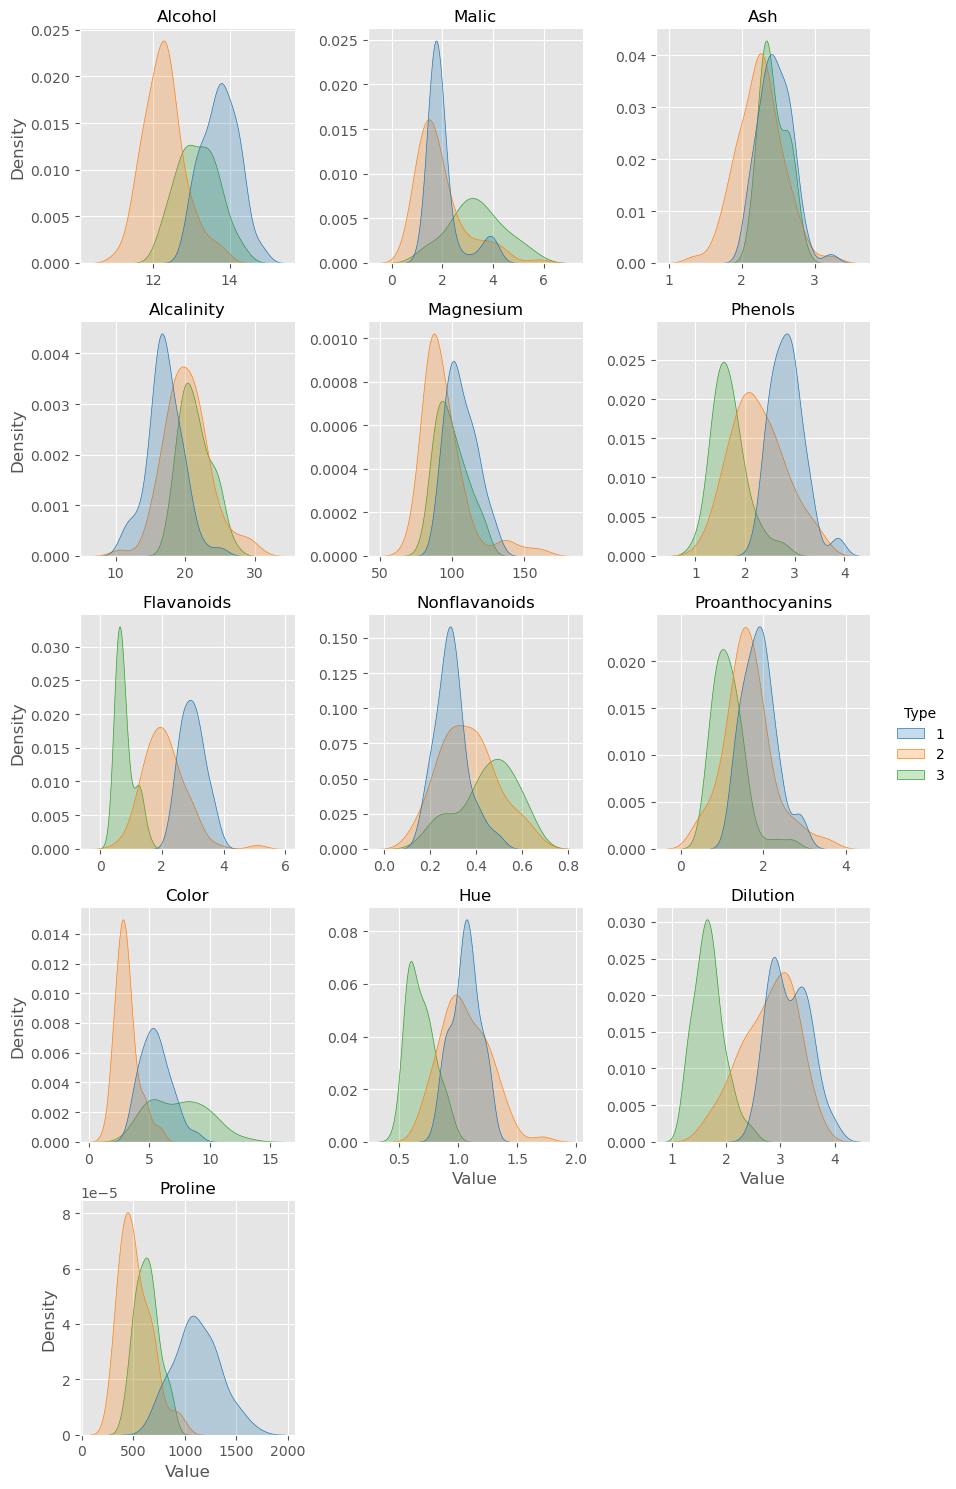

In [11]:
# 13 графиков распределения разных переменных c displot тип kde на одном поле subplots
# Использование расплавленных данных для создания графиков
g = sns.displot(
    data=melted_df,
    x='Value',
    hue='Type',
    col='Feature',
    col_wrap=3,
    height=3,
    kind='kde',
    palette='tab10',
    fill=True,
    facet_kws={'sharey': False, 'sharex': False}
)

g.set_titles('{col_name}')
plt.show()

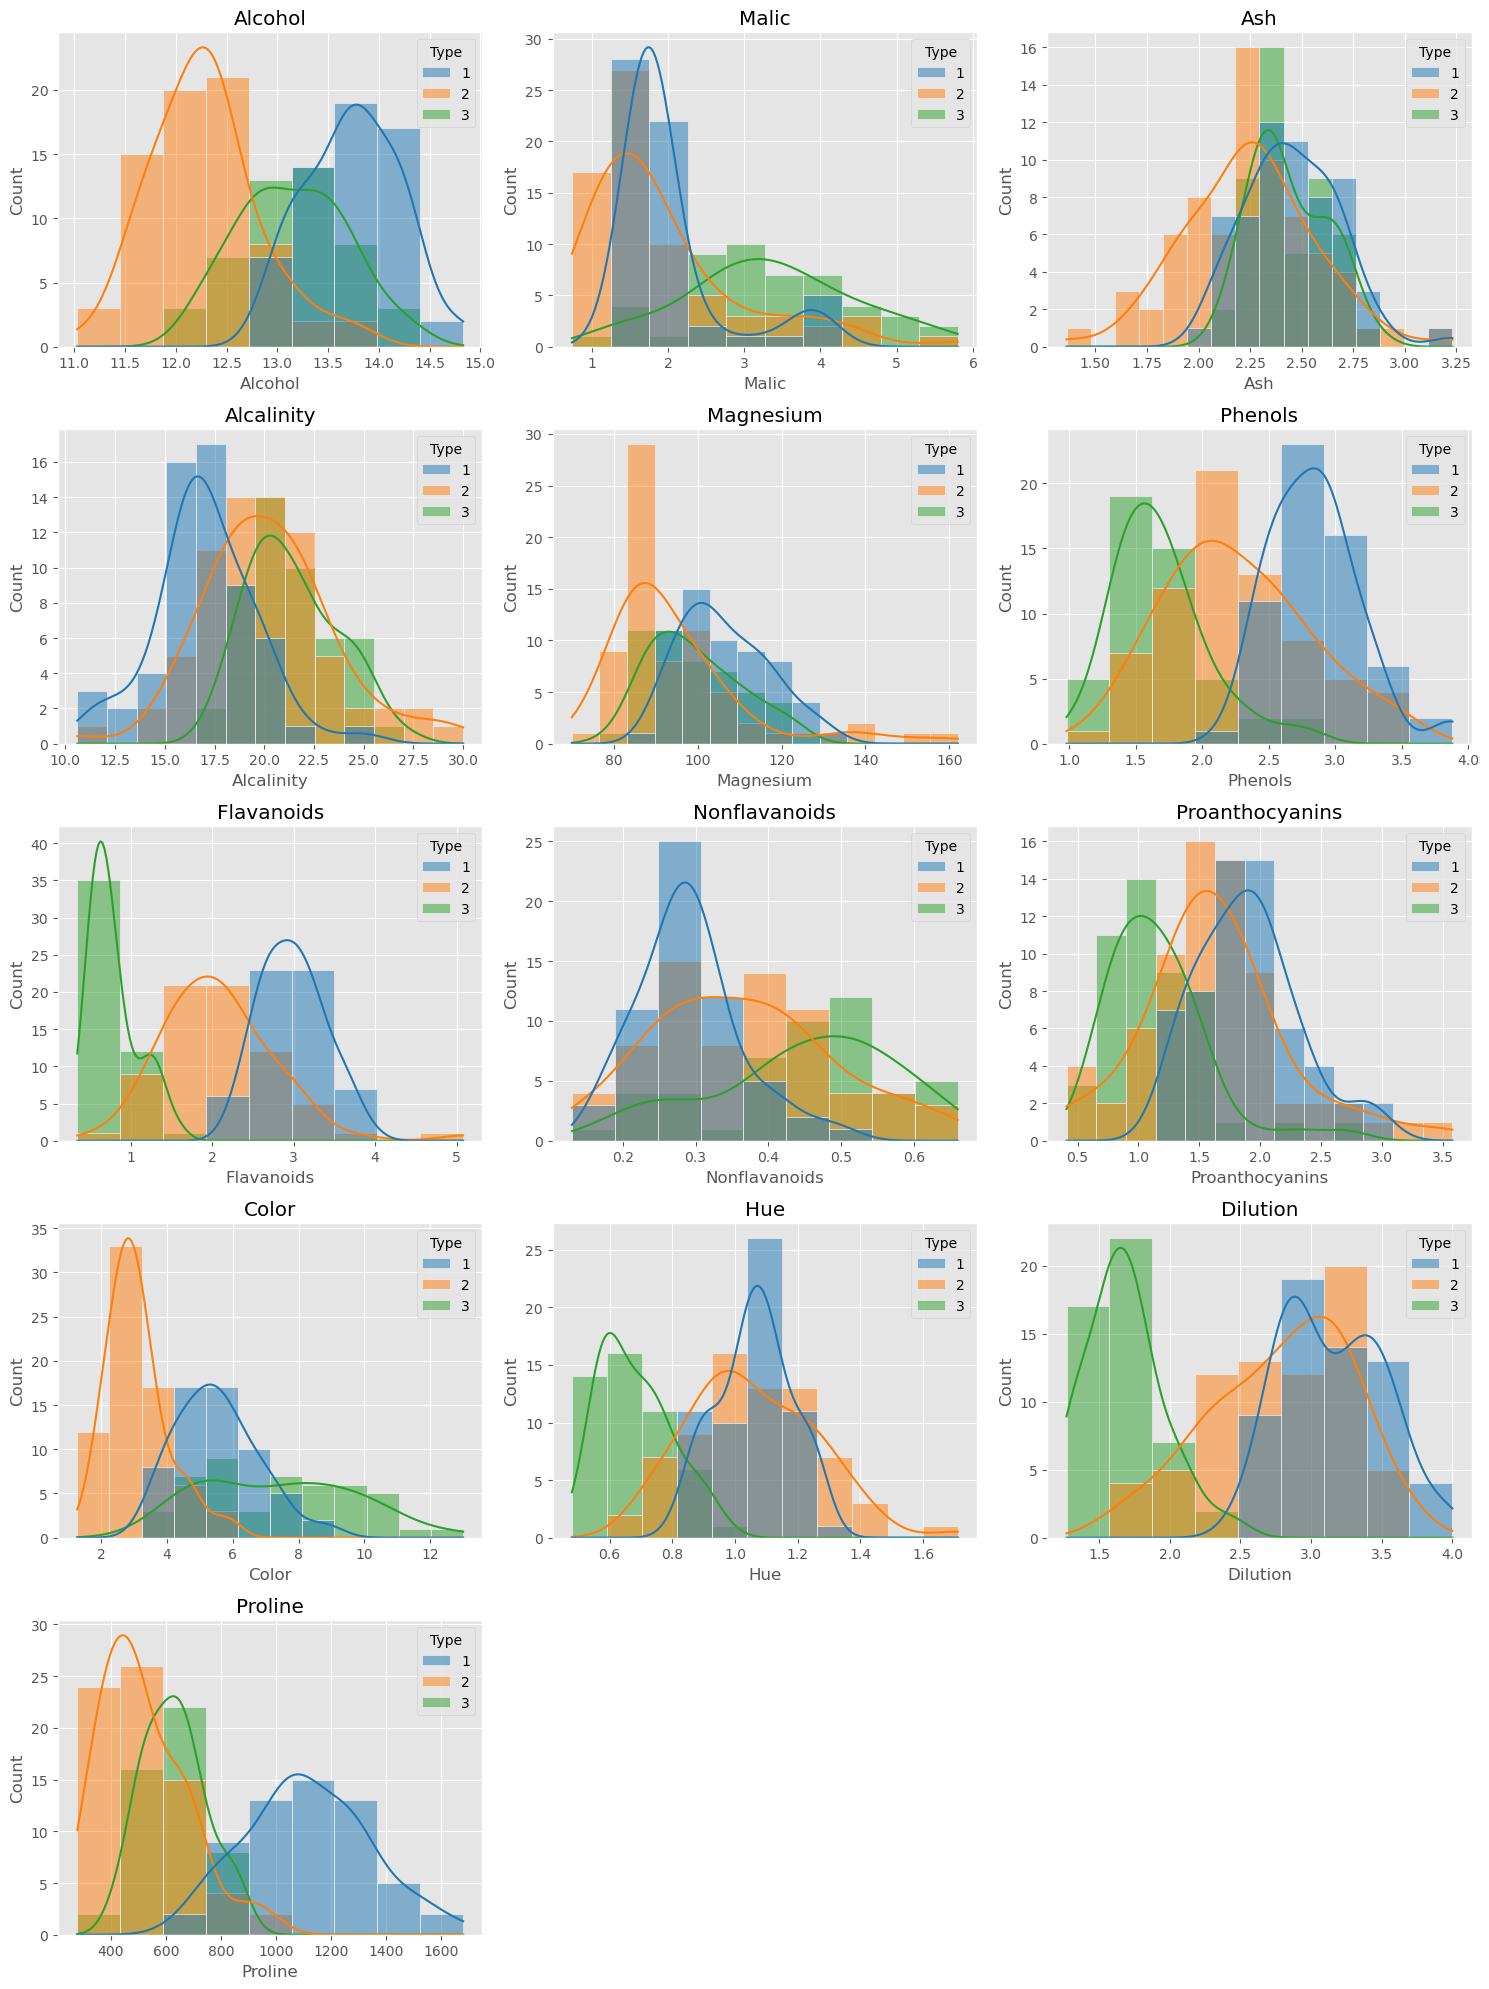

In [12]:
# Настройка размера фигуры
plt.figure(figsize=(15, 20))

# 13 графиков распределения разных переменных c histplot c kde на одном поле subplots
for i, feature in enumerate(df.columns[1:], 1):
    plt.subplot(5, 3, i)
    sns.histplot(data=df,
                 x=feature,
                 hue='Type',
                 kde=True,
                 palette='tab10')
    plt.title(feature)

plt.tight_layout()
plt.show()

Alcohol. Из графиков видно некоторое различие в содержании алкоголя между типами вин. Вино типа 1 имеет в среднем более высокое содержание алкоголя по сравнению с остальными типами, а тип 2 в среднем менее высокое содержание алкоголя.  
Malic. Распределение яблочной кислоты также отличается между типами вин. Тип 3 охватывает весь диапазон значений и в среднем выше по содержанию.  
Ash. Различия в содержании золы между типами вин не столь заметны, но наблюдается у типа 2 чуть больший разброс и смещенность влево, в сторону меньшего содержания золы.  
Alcalinity. Типы вин немного различаются по уровню щелочности. Вино типа 1 имеет в среднем менее высокую щелочность по сравнению с другими типами.  
Magnesium. Наблюдается различие в содержании магния с наибольшими средними значениями у типа 1, а у типа 2 в среднем менее высокое содержание магния.  
Phenols. Наблюдается различие в содержании фенолов с наибольшими средними значениями у типа 1, а у типа 3 в среднем менее высокое содержание фенолов.  
Flavanoids. Различия в содержании флавоноидов между типами вин ярко выражены, особенно между типами 1 (с наибольшими средними значениями) и 3 (с наименьшими средними значениями).  
Nonflavanoids. Различия в содержании нефлавоноидов также есть, теперь в среднем наименьшее содержание у типа 1, а наибольшее содержание у типа 3.  
Proanthocyanins. Есть некоторые различия в содержании проантоцианов между типами с наибольшими средними значениями у типа 1, а у типа 3 в среднем менее высокое содержание проантицианов.  
Color. Заметны различия в цвете вина между разными типами. У типа 2 в среднем меньшая интенсивность цвета по сравнению с другими типами, а тип 3 охватывает весь диапазон интенсивности цвета.  
Hue. Оттенок вина различается между типами, тип 3 имеет более светлые оттенки по сравнению с другими типами.  
Dilution. Есть различия в разбавленности вина, у типа 3 в среднем наименьшие значения по данному показателю.  
Proline. Есть различия в содержании пролина между типами вин, наибольшие средние значения у типа 1, а тип 2 в среднем имеет менее высокое содержание пролина. 

Тип 1 часто выделяется не только более высокими значениями многих характеристик (Alcohol, Magnesium, Phenols, Flavanoids, Proanthocyanins, Proline), но и менее высокими значениями в среднем (Alcalinity, Nonflavanoids)  
Тип 2 выделяется менее высокими значениями в среднем (Alcohol, Ash, Magnesium, Color, Proline)  
Тип 3 выделяется менее высокими значениями (Phenols, Flavanoids, Proanthocyanins, Hue, Dilution), более высокими значениями в среднем (Nonflavanoids), весь диапазон значений (Malic, Color)  
Такие отличия в характеристиках скорее всего помогут в задаче многоклассовой классификации - определения типа вина.

### Задание 2. Есть ли корреляции (1 балл)
Постройте `sns.heatmap` для всех числовых характеристик внутри датасета. Определите, какие три переменные больше всего коррелируют с типом вина. Добавьте стрелочки с текстом (функция `annotate`) с указанием на эти переменные.

In [13]:
# Корреляционная матрица
correlation_matrix = df.corr()

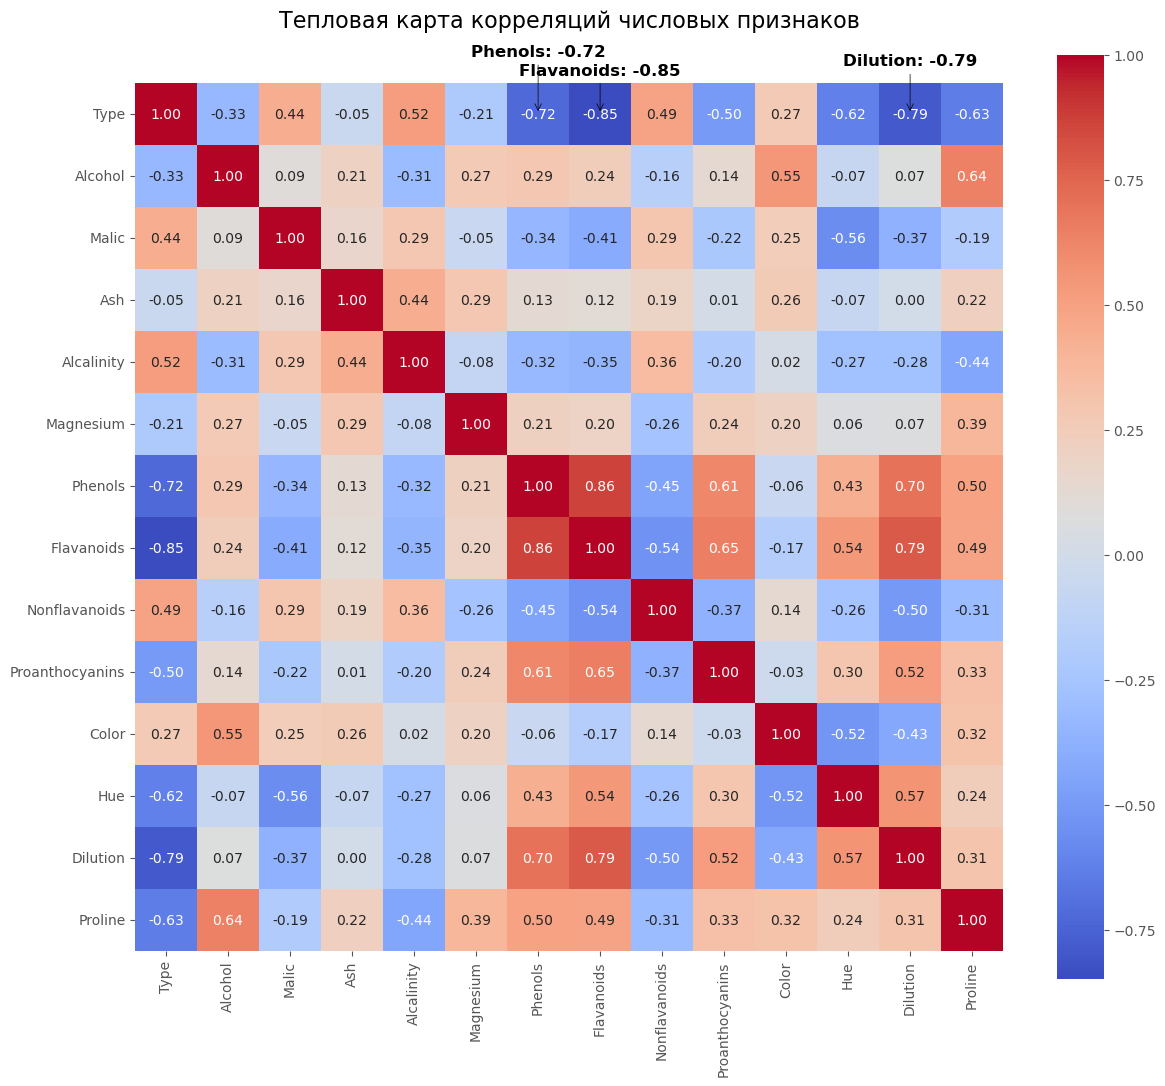

In [14]:
# Тепловая карта
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Тепловая карта корреляций числовых признаков', fontsize=16, pad=40)

# Три наиболее коррелирующие с типом вина переменные по абсолютному значению
top_correlated_features = correlation_matrix['Type'].abs().sort_values(ascending=False)[1:4].index

# Отступ сверху для аннотаций
annotation_y_position = -0.2

# Аннотации со стрелками
for i, feature in enumerate(top_correlated_features):
    # Середина квадрата
    x = df.columns.get_loc(feature) + 0.5
    y = df.columns.get_loc('Type') + 0.5
    # Текст сверху от тепловой карты с учетом смещения для каждой аннотации
    xytext = (x, annotation_y_position - (i*0.15))  
    text = f"{feature}: {correlation_matrix.at['Type', feature]:.2f}"
    # Черные стрелки с текстом
    heatmap.annotate(text, xy=(x, y), xytext=xytext, arrowprops=dict(arrowstyle='->', color='black'),
                     ha='center', va='center', fontsize=12, weight='bold')

plt.show()

Самая высокая положительная корреляция с типом вина наблюдается у признака Alcalinity (0.52)

Самая сильные отрицательные корреляции наблюдаются у Flavanoids (-0.85), Dilution (-0.79), Phenols (-0.72).

### Задание 3. Сохранение доли объясненной дисперсии в зависимости от n_components (2 балла)
Воспользуйтесь методом понижения размерности PCA с разным параметром `n_components` — от 1 до 10. Постройте линейный график совокупной объясненной дисперсии при добавлении каждой новой компоненты.

На том же полотне постройте столбчатую диаграмму: каждый столбец должен показывать, сколько объясненной дисперсии вносит каждая следующая компонента.

In [15]:
# PCA с 10 компонентами
pca = PCA(n_components=10, random_state=42)
data_pca = pca.fit_transform(df.drop(columns=['Type']))

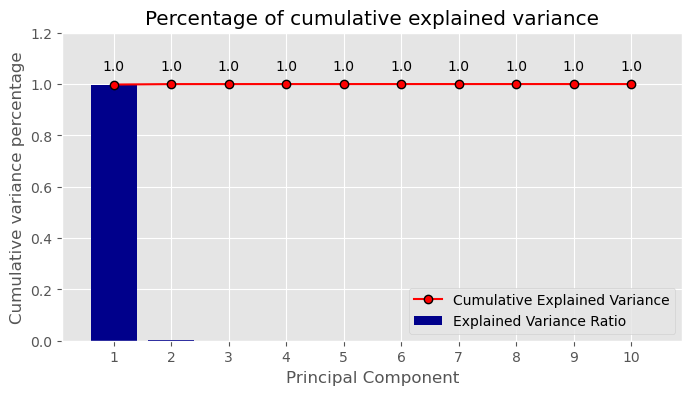

In [16]:
# Объясненная дисперсия для каждой компоненты
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Построение линейного графика и столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8, 4))

# Линейный график совокупной объясненной дисперсии
ax.plot(np.arange(len(pd.DataFrame(data_pca).columns)) + 1,
        cumulative_explained_variance,
        marker='o',
        color='red',
        markeredgecolor = 'black',
        label='Cumulative Explained Variance')

# Столбчатая диаграмма для объясненной дисперсии каждой компоненты
ax.bar(np.arange(pca.n_components_) + 1,
       explained_variance_ratio,
       color = 'darkblue',
       label='Explained Variance Ratio')

# Добавление аннотаций к линейному графику
for i, v in enumerate(cumulative_explained_variance):
    ax.annotate(round(v, 2), (i + 1, v), textcoords='offset points', xytext=(0,10), ha='center')

# Настройка диаграммы
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Percentage of cumulative explained variance')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative variance percentage')
ax.legend()

plt.show()

In [17]:
cumulative_explained_variance

array([0.99809123, 0.99982715, 0.99992211, 0.99997232, 0.99998469,
       0.99999315, 0.99999596, 0.99999748, 0.99999861, 0.99999933])

Совокупная объясненная дисперсия после добавления первой компоненты достигает почти 100%. Дополнительные компоненты (со второй по десятую) вносят очень мало дополнительной информации.

### Задание 4. Сравнение результатов работы разных алгоритмов понижения размерности (3 балла)
Воспользуйтесь четырьмя любыми алгоритмами понижения размерности (`n_components` возьмите равным 2 или 3).

Создайте поле с двумерными или трехмерными графиками, на которых будут отображены результаты работы каждого алгоритма, а цветом будет обозначен тип вина (наша зависимая переменная).

Визуально оцените графики и сделайте вывод о том, какой метод отработал лучше.

Опишите результаты и качественно обоснуйте ваш выбор лучшего алгоритма. Если невозможно выбрать лучший алгоритм, также обоснуйте почему.

In [18]:
# Подготовка данных
X = df.drop('Type', axis=1)
y = df['Type']

In [19]:
def check_reduction_algo(X, y, standard_scaler=False):
    '''
    Функция стандартизирует данные, если это указано. Затем применяет четыре различных
    алгоритма понижения размерности PCA, LDA, TSNE и UMAP с количеством компонентов 2.
    Для каждого из алгоритмов на одном поле создается двумерный график с результатами понижения 
    размерности, где точки окрашены в соответствии с метками классов y.
    
    Параметры:
    X: array-like, shape (n_samples, n_features)
        Матрица признаков для понижения размерности.
    
    y: array-like, shape (n_samples,)
        Целевая переменная или метки классов.
    
    standard_scaler: bool, optional, default=False
        Если True, применяет стандартизацию к матрице признаков перед понижением размерности.
    
    Возвращает:
    None. Отображает графики с результатами понижения размерности
    
    '''
    if standard_scaler:
        # Нормализация данных
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Инициализация моделей, возьмем n_components=2, поскольку, как показал PCA из предыдущего задания, достаточно 2
    pca = PCA(n_components=2, random_state=42)
    lda = LDA(n_components=2)
    tsne = TSNE(n_components=2, random_state=42)
    umap_model = umap.UMAP(n_components=2, random_state=42)

    # Применение моделей
    X_pca = pca.fit_transform(X)
    X_lda = lda.fit_transform(X, y)
    X_tsne = tsne.fit_transform(X)
    X_umap = umap_model.fit_transform(X)
    
    # Создание графиков
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Цветовая палитра
    palette = sns.color_palette('tab10', n_colors=len(np.unique(y)))

    algorithms = [(X_pca, 'PCA'), (X_lda, 'LDA'), (X_tsne, 'TSNE'), (X_umap, 'UMAP')]
    for ax, (data, title) in zip(axes.flatten(), algorithms):
        sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y, palette=palette, ax=ax, legend='full', s=50)
        ax.set_title(title)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')

    plt.tight_layout()
    plt.show()

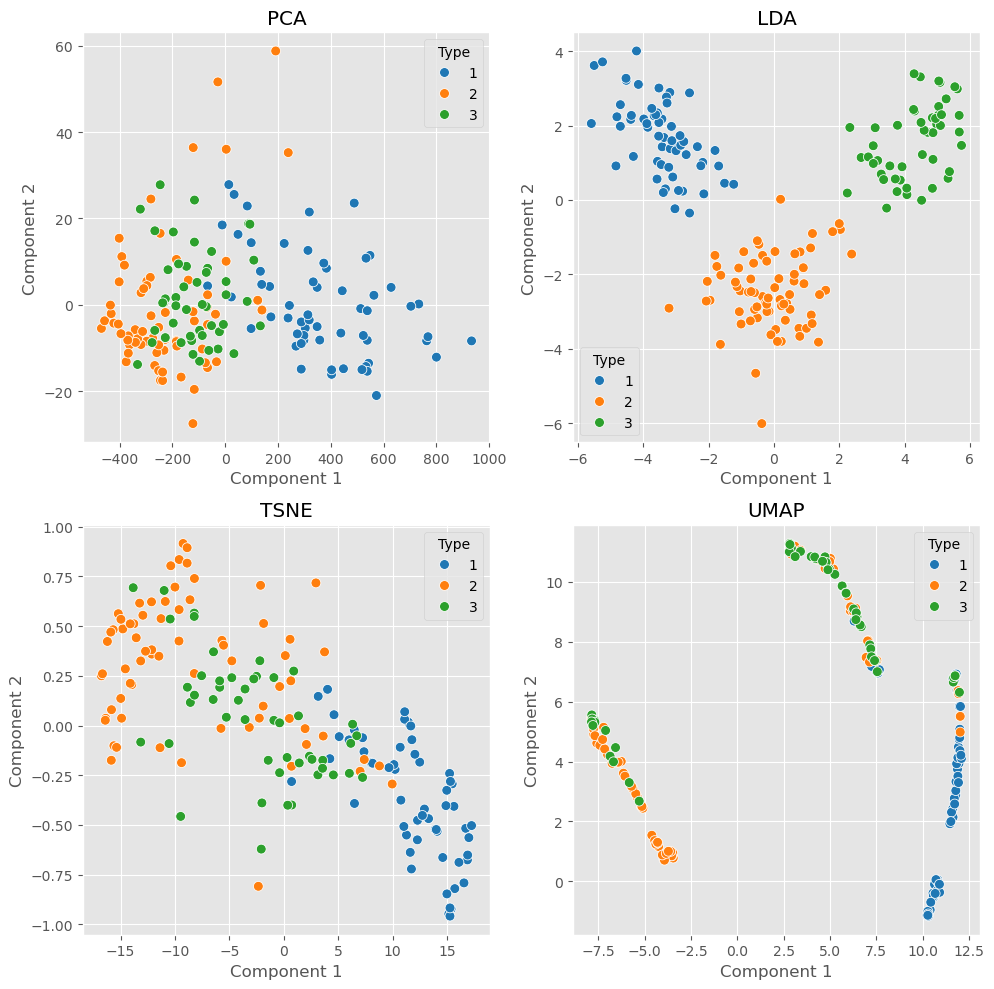

In [20]:
# Без стандартизации
check_reduction_algo(X, y)

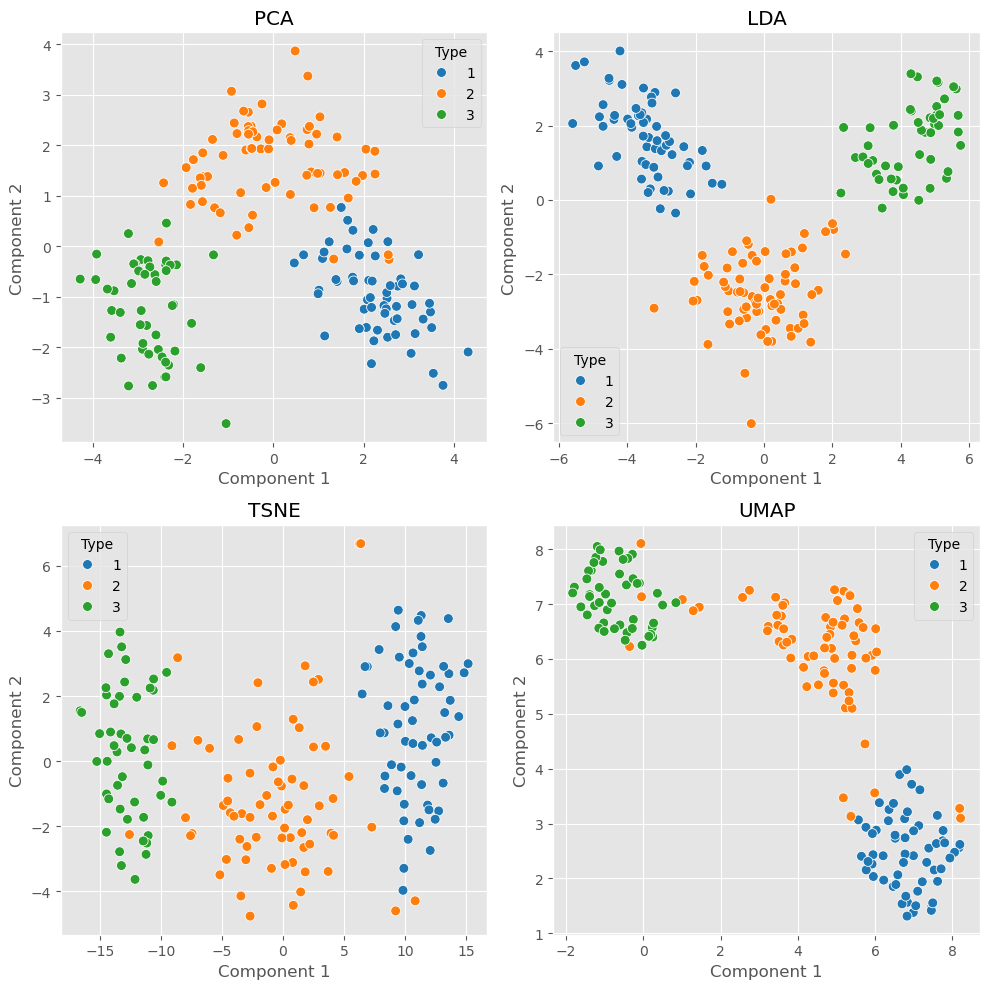

In [21]:
# Со стандартизацией
check_reduction_algo(X, y, standard_scaler=True)

PCA. С данными без стандартизации, алгоритм разбросал точки в широком диапазоне по первой компоненте, типы смешиваются и не формируют отдельные кластеры, но после стандартизации смог довольно неплохо выделить типы вин на основе двух компонент.  
LDA. Видно четкое разделение между тремя типами вина независимо от применения стандартизации. Алгоритм максимизирует различия между классами, эффективен для линейно разделимых данных.  
TSNE. С данными без стандартизации, алгоритм выделил кластеры с перекрытием, что уже лучше по сравнению с PCA. Еще лучше разделение на типы со стандартизацией. Однако кластеры не так разделены, как в LDA, и есть пересечения.  
UMAP. С данными как без стандартизации, так и со станадартизацией, показал хорошее разделение между классами, с кластерами, расположенными последовательно вдоль кривой, но наблюдается небольшое перекрытие между типами.  
Исходя из этого, визуально LDA (особенно) и UMAP показывают себя как более эффективные методы разделения типов вина, по сравнению с PCA и TSNE.

### Задание 5. Сравнение результатов работы алгоритмов (4 балла)
Разделите выборку на обучающую и тестовую.

Используйте два метода понижения размерности, которые лучше всего показали себя в предыдущем задании, а также исходные данные без понижения размерности.

Примените 6 любых алгоритмов классификации на этих трех типах данных.

Постройте два `sns.heatmap()` (для `train` и `test`). В каждом из них должно быть по 18 ячеек (6 алгоритмов х 3 вида данных) — в каждой ячейке должно быть указано значение `Accuracy` для определенного алгоритма с определенными данными. Аналогичную работу мы проделывали на семинаре.

Определите, какой алгоритм дал лучшие результаты и дайте письменное обоснование своего решения:

- Как алгоритмы отрабатывают при работе на данных без понижения размерности?
- В чем разница в полученных значениях?

In [22]:
# Перекодировка меток классов, чтобы они начинались с 0 для моделей
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [23]:
y_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int64)

In [24]:
# Random state
SEED = 42

In [25]:
def check_algo(X, y, size=0.3, standard_scaler=False):
    '''
    Функция разделяет данные на обучающую и тестовую выборки с возможностью стандартизации данных.
    Применяет LDA и UMAP для понижения размерности. Инициализирует и обучает 6 видов моделей классификации
    с вычисление accuracy на обучающей и тестовой выборках. Визуализирует результаты в виде тепловых карт.

    Параметры:
    X : array-like, shape (n_samples, n_features)
        Матрица признаков для классификации.
    y : array-like, shape (n_samples,)
        Целевая переменная для классификации.
    size : float, опционально, по умолчанию 0.3
        Доля тестовой выборки.
    standard_scaler : bool, опционально, по умолчанию False
        Если True, применяет стандартизацию к данным перед классификацией.

    Возвращает:
    None. Выводит на экран тепловые карты точности обучения и тестирования для различных моделей.
    
    '''
    # Разделение на обучающую и тестовую выборки, нормализация данных
    if standard_scaler:
        scaler = StandardScaler()
        X_train, X_test, y_train, y_test = tts(X, y, test_size=size, random_state=SEED)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    else:
        X_train, X_test, y_train, y_test = tts(X, y, test_size=size, random_state=SEED)
        
    # Применение LDA и UMAP
    lda = LDA(n_components=2)
    umap_model = umap.UMAP(n_components=2, random_state=SEED)

    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    X_train_umap = umap_model.fit_transform(X_train)
    X_test_umap = umap_model.transform(X_test)
    
    # Инициализация моделей классификации
    models = [
        LogisticRegression(random_state = SEED),
        RandomForestClassifier(random_state = SEED),
        ExtraTreesClassifier(random_state = SEED),
        XGBClassifier(random_state = SEED),
        LGBMClassifier(random_state = SEED, verbosity=-1),
        CatBoostClassifier(random_state = SEED, verbose=0)
    ]
    
    # Словари для результатов
    train_scores = { 'Original': [], 'LDA': [], 'UMAP': [] }
    test_scores = { 'Original': [], 'LDA': [], 'UMAP': [] }

    # Обучение моделей и расчет точности
    for model in tqdm(models):
        name = type(model).__name__
        # Данные без понижения размерности
        model.fit(X_train, y_train)
        train_scores['Original'].append(accuracy_score(y_train, model.predict(X_train)))
        test_scores['Original'].append(accuracy_score(y_test, model.predict(X_test)))

        # LDA
        model.fit(X_train_lda, y_train)
        train_scores['LDA'].append(accuracy_score(y_train, model.predict(X_train_lda)))
        test_scores['LDA'].append(accuracy_score(y_test, model.predict(X_test_lda)))

        # UMAP
        model.fit(X_train_umap, y_train)
        train_scores['UMAP'].append(accuracy_score(y_train, model.predict(X_train_umap)))
        test_scores['UMAP'].append(accuracy_score(y_test, model.predict(X_test_umap)))

        print(f'* {name} finished.')

    # Преобразование результатов в DataFrame
    train_df = pd.DataFrame(train_scores, index=[type(model).__name__ for model in models])
    test_df = pd.DataFrame(test_scores, index=[type(model).__name__ for model in models])
    
    # Визуализация тепловых карт
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.heatmap(train_df, annot=True, fmt='.4f', ax=ax[0], cmap='Blues', vmin=0.0, vmax=1.0, cbar = False)
    ax[0].set_title('Train Accuracy Scores')

    sns.heatmap(test_df, annot=True, fmt='.4f', ax=ax[1], cmap='Greens', vmin=0.0, vmax=1.0, cbar = False)
    ax[1].set_title('Test Accuracy Scores')

    plt.tight_layout()
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

* LogisticRegression finished.
* RandomForestClassifier finished.
* ExtraTreesClassifier finished.
* XGBClassifier finished.
* LGBMClassifier finished.
* CatBoostClassifier finished.


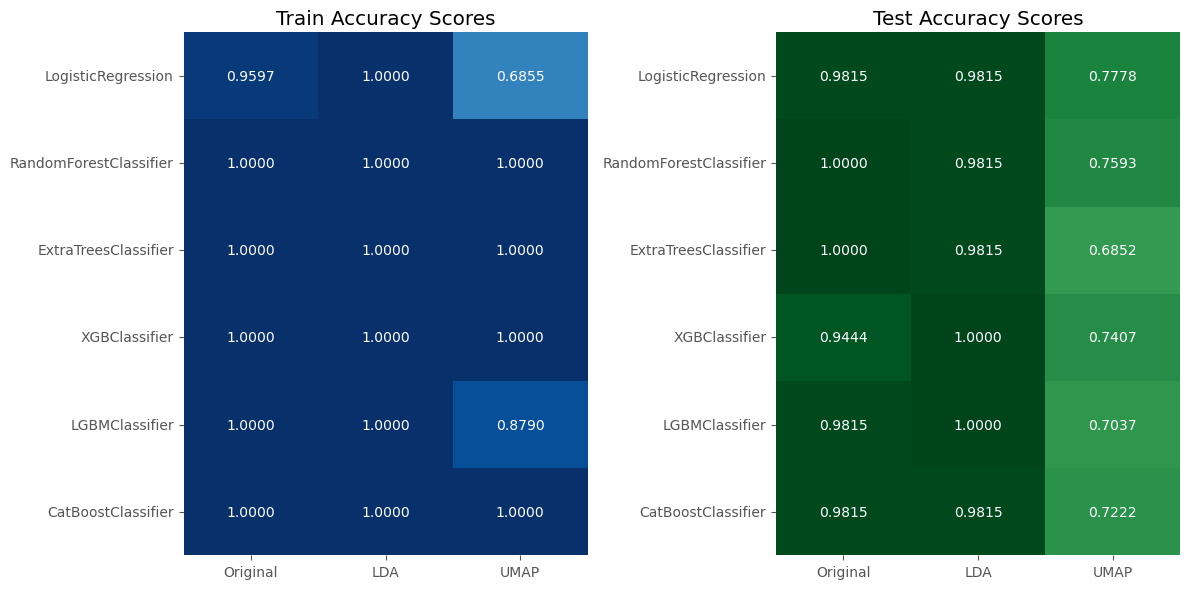

In [26]:
# Без стандартизации
check_algo(X, y_encoded, size=0.3)

  0%|          | 0/6 [00:00<?, ?it/s]

* LogisticRegression finished.
* RandomForestClassifier finished.
* ExtraTreesClassifier finished.
* XGBClassifier finished.
* LGBMClassifier finished.
* CatBoostClassifier finished.


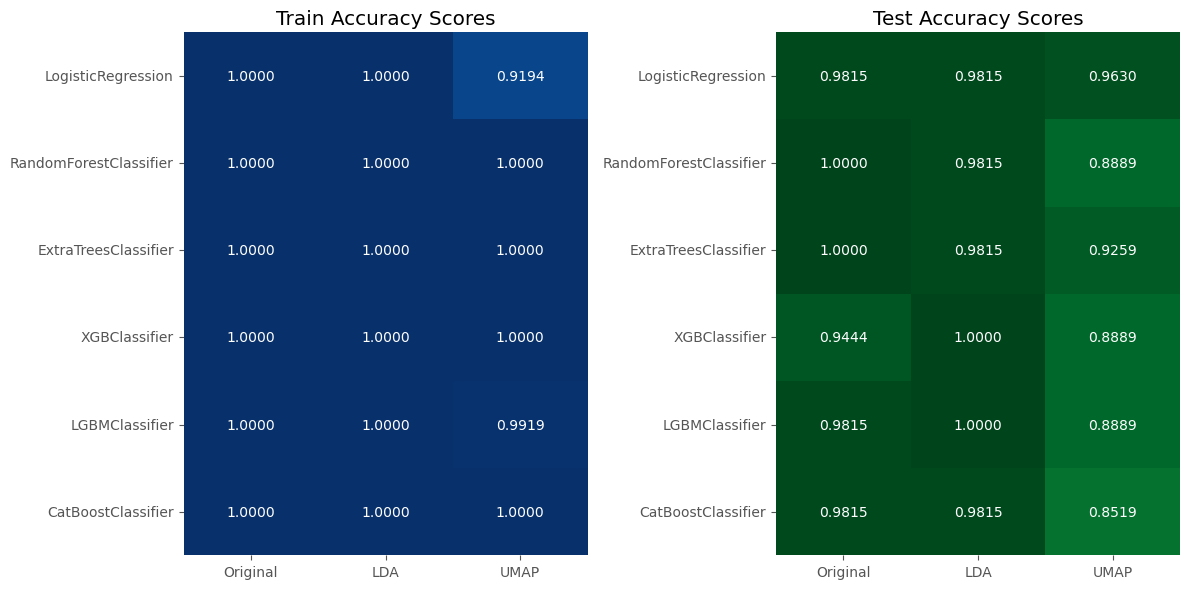

In [27]:
# Со стандартизацией
check_algo(X, y_encoded, size=0.3, standard_scaler=True)

Тестовая выборка 30%. На обучающих данных практически все модели показали accuracy 1, кроме Logistic Regression (на оригинальных данных-0.9597 и с UMAP-0.6855 без стандартизации, на UMAP-0.9194 со стандартизацией) и LGBMClassifier (на UMAP без стандартизации-0,879 и со стандартизацией-0.9919, что близко к 1).  

На тестовых данных точность моделей варьируется, и в целом, показывают более низкую точность по сравнению с обучающей выборкой, скорее всего из-за переобучения и влияния неизвестных данных.  
При применении UMAP снижается точность на тестовых данных сильнее, кроме LogisticRegression (здесь она выше, что тоже говорит о некачественном обучении), (без стандартизации точность ниже, чем со стандартизацией), чем на исходных данных без понижения размерности или при использовании LDA. Это может указывать на то, что в процессе понижения размерности была потеряна важная информация, что привело к снижению способности модели правильно классифицировать новые данные.  
На тестовых данных точность моделей, обученных на исходных данных без понижения размерности и с использованием LDA (стабильнее, по совокупности моделей в плане точности), осталась высокой, причем независимо от стандартизации. Это указывает на хорошую обобщающую способность этих моделей и эффективность LDA в сохранении дискриминативных признаков, необходимых для классификации.  
XGBClassifier на тестовых данных без понижения размерности показал в отличие от других моделей немного меньшую точность (0.944), но она все равно высокая. RandomForestClassifier и ExtraTreesClassifier и с тестовыми данными без понижения размерности показали идеальную точность (1.0000).  
На тестовых данных при использовании LDA все модели показали точность около 0.98, а XGBClassifier и LGBMClassifier дали идеальную точность (1.0000).  

Исходя из вышеупомянутого и тепловых карт, лучшим алгоритмом можно выбрать тот, кто показывает высокую точность и стабильность как на обучающей выборке, так и на тестовой. Здесь подходят модели как без использования понижения размерности, например, RandomForestClassifier и ExtraTreesClassifier, так и с использованием LDA (к тому же оно показало более стабильную работу по совокупности моделей), например, XGBClassifier и LGBMClassifier. Смотря в целом, на тепловые карты по тестовым данным без стандартизации и со стандартизацией, выделим для следующего задания модель с понижением размерности при использовании LDA и LGBMClassifier.

### Задание 6. Более пристальный анализ (2 балла)
Для лучшего алгоритма из предыдущего задания постройте `Classification Report`, `Confusion Matrix`, `Precision Recall Curve`, `ROC Curve`.

Удалось ли обнаружить какие-то аномалии в работе нашего алгоритма? Можем ли мы принять полученные результаты?

In [28]:
# Бинаризация меток классов
y_bin = label_binarize(y, classes=np.unique(y))

In [29]:
# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = tts(X, y_bin, test_size=0.3, random_state=42)

# Стандартизация данных
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# LDA для понижения размерности
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train.argmax(axis=1))
X_test_lda = lda.transform(X_test)

# Обучение модели LGBMClassifier
lgbm_model = LGBMClassifier(random_state = SEED, verbosity=-1)
lgbm_model.fit(X_train_lda, y_train.argmax(axis=1))

LGBMClassifier(random_state=42, verbosity=-1)

In [30]:
# Предсказания
y_pred_train = lgbm_model.predict(X_train_lda)
y_pred_test = lgbm_model.predict(X_test_lda)
y_pred_proba_train = lgbm_model.predict_proba(X_train_lda)
y_pred_proba_test = lgbm_model.predict_proba(X_test_lda)

In [31]:
# Classification Report для обучающей выборки
print('Classification Report for Training Set:\n')
print(classification_report(y_train.argmax(axis=1), y_pred_train))

# Classification Report для тестовой выборки
print('\nClassification Report for Test Set:\n')
print(classification_report(y_test.argmax(axis=1), y_pred_test))

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        34

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        14

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



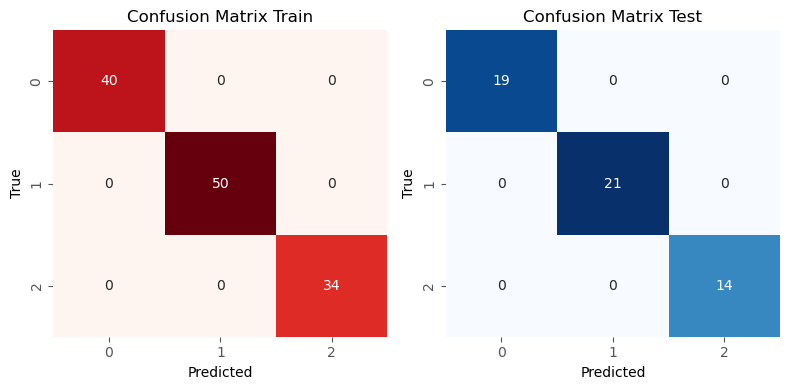

In [32]:
# Confusion Matrix
cf_mx_train = confusion_matrix(y_train.argmax(axis=1), y_pred_train)
cf_mx_test = confusion_matrix(y_test.argmax(axis=1), y_pred_test)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, fmt = 'd', cbar = False, ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, fmt = 'd', cbar = False, ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 10, color = 'black')
axs[1].set_xlabel('Predicted', fontsize = 10, color = 'black')
axs[0].set_ylabel('True', fontsize = 10, color = 'black')
axs[1].set_ylabel('True', fontsize = 10, color = 'black')
axs[0].set_title('Confusion Matrix Train', fontsize = 12)
axs[1].set_title('Confusion Matrix Test', fontsize = 12)

fig.tight_layout()
fig.show()

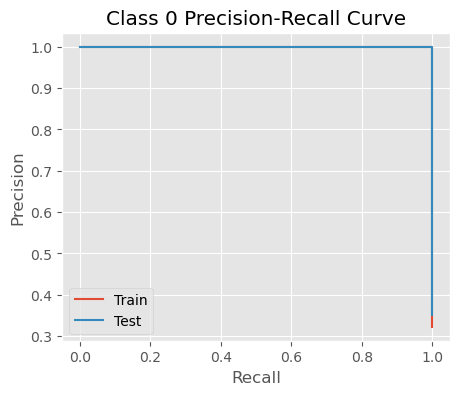

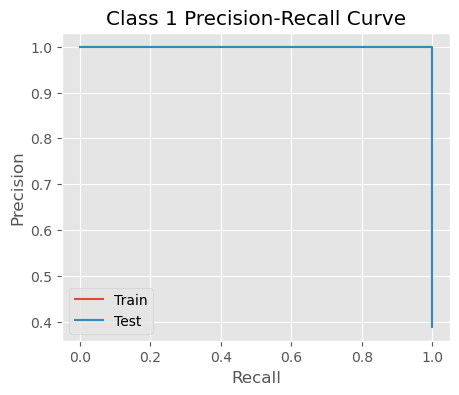

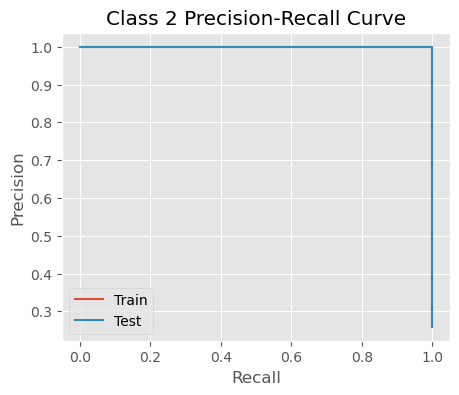

In [33]:
# Precision-Recall Curve
n_classes = y_train.shape[1]

for i in range(n_classes):
    precision_train, recall_train, _ = precision_recall_curve(y_train[:, i], y_pred_proba_train[:, i])
    precision_test, recall_test, _ = precision_recall_curve(y_test[:, i], y_pred_proba_test[:, i])

    plt.figure(figsize = (5, 4))
    plt.plot(recall_train, precision_train, label='Train')
    plt.plot(recall_test, precision_test, label='Test')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Class {i} Precision-Recall Curve')
    plt.legend()
    plt.show()

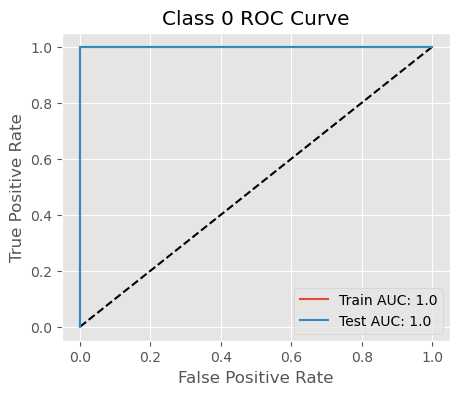

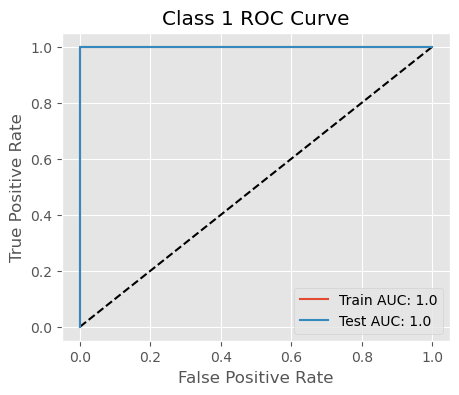

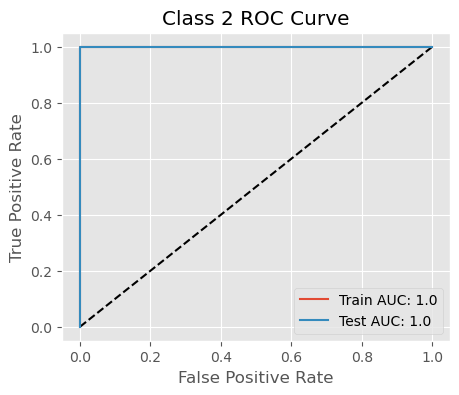

In [34]:
# ROC Curve
# fpr и tpr для ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train[:, i], y_pred_proba_train[:, i])
fpr_test, tpr_test, _ = roc_curve(y_test[:, i], y_pred_proba_test[:, i])
for i in range(n_classes):
    plt.figure(figsize = (5, 4))
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.plot(fpr_train, tpr_train, label='Train AUC: ' + str(auc(fpr_train, tpr_train)))
    plt.plot(fpr_test, tpr_test, label='Test AUC: ' + str(auc(fpr_test, tpr_test)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Class {i} ROC Curve')
    plt.legend()
    plt.show()

При применении понижения размерности LDA, а затем использование LGBMClassifier получили идеальные метрики как на обучающей, так и на тестовой выборке. Возможно данные хорошо структурированы и содержат очевидные признаки, которые легко разделяют, позволяют хорошо классифицировать наблюдения. В данном датасете признаки, как химический состав, возможно указывают напрямую определенный тип вина.  
Чтобы проверить, стоит ли точно принять такой результат, можно дополнительно провести кросс-валидацию для проверки стабильности результатов. Также кол-во наблюдений не такое большое - 178, было бы интересно расширить их кол-во и провести дополнительное обучение и тестирование, и поменять размер тестовой выборки. Возможна дополнительная визуализация работы алгоритма, чтобы понять как модель принимает решения и какие признаки влияют на эти решения.